## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

Adding features to this dataset can help us better understand it. Let's start with some simple calendar features like day of week and time of day. 

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import holidays
from darts import TimeSeries
from darts.models import NaiveSeasonal, Theta, RegressionModel, LightGBMModel
from darts.metrics import mape, rmse, mae

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
load_df = load_df.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3', axis=1)   
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data - adjust column names as needed
date_col = 'Datum'  # Adjust this to your actual date column name
time_col = 'Tid (UTC)'  # Adjust this to your actual time column name

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)

# Remove any duplicates in temperature data
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")

# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# Adding Holidays
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int(date in Sweden_holidays) for date in load_df.datetime]

# Reorder columns
load_df = load_df[['datetime', 'Load', 'Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df



Load data shape before merge: (17544, 2)
Load data shape after merge: (17544, 3)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

,datetime,Load,Temperature,Day_of_week,Hour_of_day,Holidays
0,2023-01-01 00:00:00,8943,3.6,6,0,1
1,2023-01-01 01:00:00,8929,3.0,6,1,1
2,2023-01-01 02:00:00,8887,2.6,6,2,1
3,2023-01-01 03:00:00,8859,2.4,6,3,1
4,2023-01-01 04:00:00,8880,2.0,6,4,1
...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,11092,-2.1,1,19,1
17540,2024-12-31 20:00:00,10798,-1.8,1,20,1
17541,2024-12-31 21:00:00,10531,-3.0,1,21,1
17542,2024-12-31 22:00:00,10165,-2.7,1,22,1


CatBoost MAE: 499.87, RMSE: 621.20, MAPE: 0.05


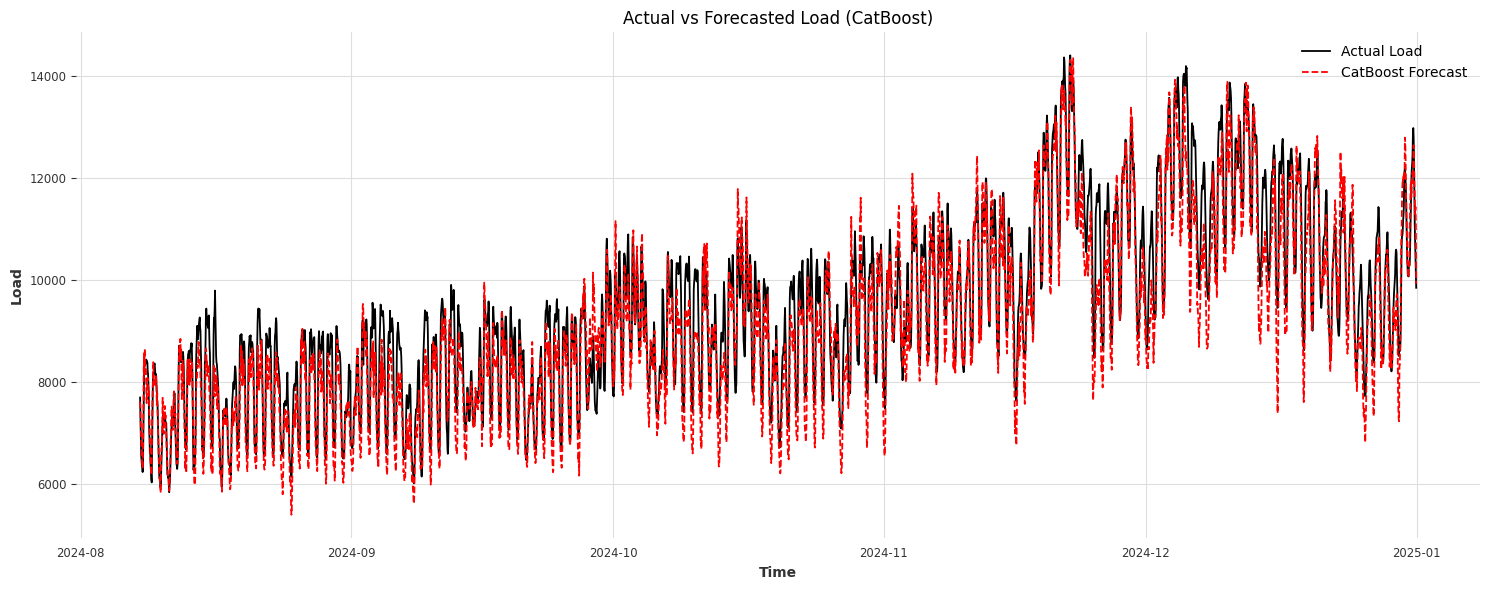

In [75]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Make sure datetime is parsed
#load_df['datetime'] = pd.to_datetime(load_df['datetime'])
load_df = load_df.set_index('datetime')

# Drop NA if any
#load_df = load_df.dropna()

# Define Features and Target
X = load_df[['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays']]
y = load_df['Load']

# Split data (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# --- Train CatBoost ---
cat_model = CatBoostRegressor(
    iterations=3000, learning_rate=0.05, depth=10,
    verbose=0
)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# --- Evaluation ---
cat_mae = mean_absolute_error(y_test, cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))
cat_mape = mean_absolute_percentage_error(y_test, cat_pred)

print(f"CatBoost MAE: {cat_mae:.2f}, RMSE: {cat_rmse:.2f}, MAPE: {cat_mape:.2f}")

# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='Actual Load', color='black')
plt.plot(y_test.index, cat_pred, label='CatBoost Forecast', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load (CatBoost)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Split into training (up to the last 24 hours) and testing
X_train1 = X.iloc[:-24]
y_train1 = y.iloc[:-24]

# --- Train the CatBoost Model ---
learning_rates = [0.01, 0.05, 0.1]
iterations_rates = [500, 1000, 3000]

for lr in learning_rates:
    for ir in iterations_rates:
        model = CatBoostRegressor(learning_rate=lr, iterations=ir, depth=6, verbose=0)
        model.fit(X_train1, y_train1, eval_set=(X_test, y_test), early_stopping_rounds=50)
        preds = model.predict(X_test)
        print(f"Learning Rate {lr} {ir} - MAE: {mean_absolute_error(y_test, preds):.2f}")
        print(f"Learning Rate {lr} {ir} - RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")

Learning Rate 0.01 500 - MAE: 424.35
Learning Rate 0.01 500 - RMSE: 535.95
Learning Rate 0.01 1000 - MAE: 408.56
Learning Rate 0.01 1000 - RMSE: 513.42
Learning Rate 0.01 3000 - MAE: 392.77
Learning Rate 0.01 3000 - RMSE: 493.38
Learning Rate 0.05 500 - MAE: 394.69
Learning Rate 0.05 500 - RMSE: 495.42
Learning Rate 0.05 1000 - MAE: 383.95
Learning Rate 0.05 1000 - RMSE: 482.60
Learning Rate 0.05 3000 - MAE: 363.20
Learning Rate 0.05 3000 - RMSE: 457.61
Learning Rate 0.1 500 - MAE: 385.16
Learning Rate 0.1 500 - RMSE: 483.42
Learning Rate 0.1 1000 - MAE: 373.21
Learning Rate 0.1 1000 - RMSE: 469.33
Learning Rate 0.1 3000 - MAE: 345.10
Learning Rate 0.1 3000 - RMSE: 435.82


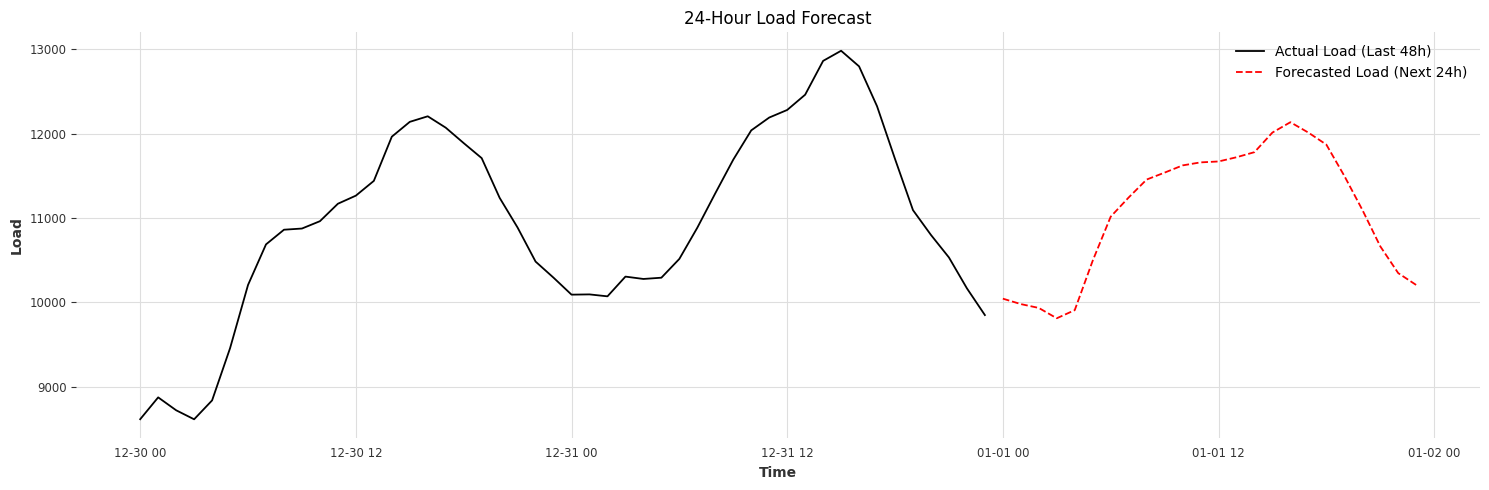

CatBoost MAE: 467.37, RMSE: 577.07, MAPE: 0.05


In [56]:
# --- Recursive Forecast for next 24 hours ---
predictions = []
X_test_init = X.iloc[-24:]  # We will predict based on the last available values
current_features = X_test_init.iloc[0].copy()

for step in range(24):
    # Predict the next load
    current_pred = model.predict(current_features.values.reshape(1, -1))[0]
    predictions.append(current_pred)
    
    # Update the features for the next prediction
    # You need to simulate how features would move forward
    # Hour advances by 1
    new_hour = (current_features['Hour_of_day'] + 1) % 24
    new_day = current_features['Day_of_week']
    new_temp = current_features['Temperature']  # Assuming temperature stays the same (or you can forecast temp separately)
    new_holiday = current_features['Holidays']

    # If hour wraps around, day advances
    if new_hour == 0:
        new_day = (new_day + 1) % 7

    # Update current_features for the next step
    current_features['Hour_of_day'] = new_hour
    current_features['Day_of_week'] = new_day
    current_features['Temperature'] = new_temp
    current_features['Holidays'] = new_holiday

# --- Create Time Index for Next 24 Hours ---
start_time = load_df.index[-1] + pd.Timedelta(hours=1)
forecast_index = pd.date_range(start=start_time, periods=24, freq='H')


model = CatBoostRegressor(learning_rate=0.1, iterations=3000, depth=6, verbose=0)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
preds = model.predict(X_test)

cat_mae = mean_absolute_error(y_test, preds)
cat_rmse = np.sqrt(mean_squared_error(y_test, preds))
cat_mape = mean_absolute_percentage_error(y_test, preds)

# --- Plot ---
plt.figure(figsize=(15,5))
plt.plot(load_df.index[-48:], load_df['Load'][-48:], label='Actual Load (Last 48h)', color='black')
plt.plot(forecast_index, predictions, label='Forecasted Load (Next 24h)', linestyle='--', color='red')
plt.title('24-Hour Load Forecast')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"CatBoost MAE: {cat_mae:.2f}, RMSE: {cat_rmse:.2f}, MAPE: {cat_mape:.2f}")

In [64]:
X_train

,Temperature,Day_of_week,Hour_of_day,Holidays
datetime,,,,
2023-01-01 00:00:00,3.6,6,0,1
2023-01-01 01:00:00,3.0,6,1,1
2023-01-01 02:00:00,2.6,6,2,1
2023-01-01 03:00:00,2.4,6,3,1
2023-01-01 04:00:00,2.0,6,4,1
...,...,...,...,...
2024-08-07 14:00:00,25.0,2,14,0
2024-08-07 15:00:00,23.9,2,15,0
2024-08-07 16:00:00,23.5,2,16,0


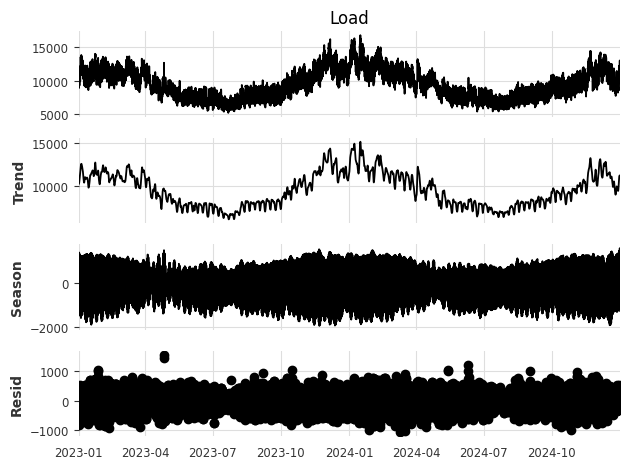

In [65]:
result = STL(load_df['Load'], period=24).fit()
_ = result.plot()

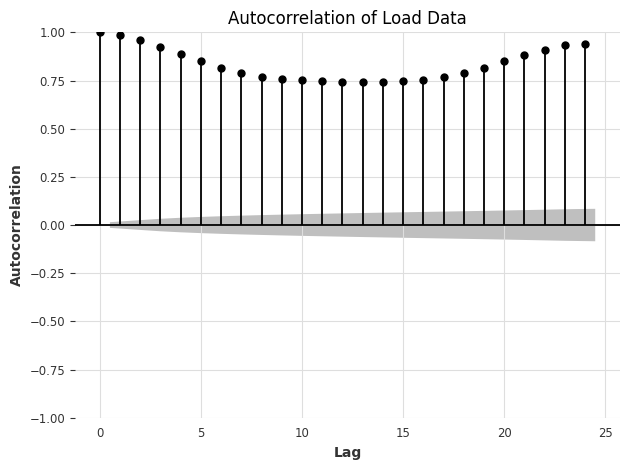

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming your data is in a DataFrame called 'data'
# and 'load' is the column you're analyzing

# Plot the ACF
plot_acf(load_df['Load'], lags=24)  # You can adjust the lags value as needed
plt.title('Autocorrelation of Load Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

In [76]:
Load

<TimeSeries (DataArray) (datetime: 17544, component: 1, sample: 1)> Size: 140kB
array([[[ 8943.]],

       [[ 8929.]],

       [[ 8887.]],

       ...,

       [[10531.]],

       [[10165.]],

       [[ 9848.]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T23:0...
  * component  (component) <U4 16B 'Load'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None